# GPS-reitin analyysi - Tehtävä 7
Analysoidaan phyphox-GPS-data: a) Reitti kartalle, b) Luotettavuus, c) Satelliitit ja tarkkuus, d) Matka Haversinella

**Kirjastojen tuonti**

In [48]:
import pandas as pd
import numpy as np
import folium
from math import radians, sin, cos, asin, sqrt
import matplotlib.pyplot as plt
from docx import Document
from docx.shared import Inches

**Datan luku ja esikäsittely**

In [49]:
# Luetaan GPS-data phyphox-tiedostosta
filename = "GPS.csv"

# Phyphox-CSV:ssä on metatietorivejä alussa, jotka alkavat "#"
df = pd.read_csv(filename, comment="#", sep=",")

print("Sarakkeet:", df.columns.tolist())
print(df.head())

# Nimetään sarakkeet yhtenäiseen muotoon
column_map = {
    "Latitude (°)": "latitude",
    "Longitude (°)": "longitude",
    "Horizontal Accuracy (m)": "accuracy",  # Muutettu oikea sarakkeen nimi
    "Satellites": "satellites",
    "Time (s)": "time"
}

df = df.rename(columns={old: new for old, new in column_map.items() if old in df.columns})

# Poistetaan rivit, joissa ei ole koordinaatteja
df = df.dropna(subset=["latitude", "longitude"])

# Järjestetään ajan mukaan
if "time" in df.columns:
    df = df.sort_values("time")

print(f"\n📊 Datapisteitä yhteensä: {len(df)}")

Sarakkeet: ['Time (s)', 'Latitude (°)', 'Longitude (°)', 'Altitude (m)', 'Altitude WGS84 (m)', 'Speed (m/s)', 'Direction (°)', 'Distance (km)', 'Horizontal Accuracy (m)', 'Vertical Accuracy (m)', 'Satellites']
   Time (s)  Latitude (°)  Longitude (°)  Altitude (m)  Altitude WGS84 (m)  \
0  0.005050     62.501261      25.432891    173.783178          193.432929   
1  0.005739     62.501261      25.432886    173.783178          193.432930   
2  0.037819     62.501261      25.432886    173.783178          193.432930   
3  1.031607     62.501267      25.432923    173.783178          193.432920   
4  1.332803     62.501273      25.432956    173.783178          193.432912   

   Speed (m/s)  Direction (°)  Distance (km)  Horizontal Accuracy (m)  \
0          NaN            NaN       0.000242                19.783260   
1          NaN            NaN       0.000264                18.566958   
2          NaN            NaN       0.002281                18.567246   
3          NaN            NaN

**a) Reitti kartalle (Folium)**

In [50]:
# Luodaan kartta reitin keskipisteeseen
center_lat = df["latitude"].mean()
center_lon = df["longitude"].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=15)

# Reitti listana [lat, lon]
route = df[["latitude", "longitude"]].values.tolist()

# Piirretään reitti sinisellä viivalla
folium.PolyLine(
    locations=route,
    weight=5,
    opacity=0.8,
    color='blue'
).add_to(m)

# Lisätään alku- ja loppupiste
folium.Marker(route[0], popup="Lähtö", icon=folium.Icon(color='green')).add_to(m)
folium.Marker(route[-1], popup="Loppu", icon=folium.Icon(color='red')).add_to(m)

# Tallennetaan kartta
map_filename = "reitti_phyphox.html"
m.save(map_filename)
print(f"🗺️ Kartta tallennettu: {map_filename}")

🗺️ Kartta tallennettu: reitti_phyphox.html


**b) Mittauksen luotettavuus**

In [51]:
# Satelliittien määrä
if "satellites" in df.columns:
    print("📡 Satelliittien määrä:")
    print(df["satellites"].describe())
    print(f"Keskimäärin: {df['satellites'].mean():.1f} satelliittia")

# GPS-tarkkuus
if "accuracy" in df.columns:
    print("\n🎯 Tarkkuus (m):")
    print(df["accuracy"].describe())
    print(f"Keskimäärin: {df['accuracy'].mean():.1f} m")

📡 Satelliittien määrä:
count    402.0
mean      -1.0
std        0.0
min       -1.0
25%       -1.0
50%       -1.0
75%       -1.0
max       -1.0
Name: satellites, dtype: float64
Keskimäärin: -1.0 satelliittia

🎯 Tarkkuus (m):
count    402.000000
mean       5.091012
std        2.270189
min        2.922515
25%        4.748651
50%        4.748652
75%        4.748652
max       23.458418
Name: accuracy, dtype: float64
Keskimäärin: 5.1 m


**c) Satelliitit ja tarkkuus kartalla**

In [52]:
# Lisätään kartalle värikoodatut pisteet tarkkuuden mukaan
def accuracy_to_color(acc):
    """Palauttaa värin tarkkuuden perusteella"""
    if acc <= 10:
        return "green"  # Hyvä tarkkuus
    elif acc <= 30:
        return "orange"  # Kohtuullinen tarkkuus
    else:
        return "red"  # Heikko tarkkuus

if "accuracy" in df.columns:
    for _, row in df.iterrows():
        folium.CircleMarker(
            location=[row["latitude"], row["longitude"]],
            radius=3,
            color=accuracy_to_color(row["accuracy"]),
            fill=True,
            fill_opacity=0.7,
            popup=f"accuracy={row['accuracy']:.1f} m" + (
                f", sat={int(row['satellites'])}" if "satellites" in df.columns and not np.isnan(row["satellites"]) else ""
            )
        ).add_to(m)

# Tallennetaan päivitetty kartta
m.save(map_filename)
print(f"✅ Kartta päivitetty tarkkuuspisteiden kanssa")

✅ Kartta päivitetty tarkkuuspisteiden kanssa


**Kuvaajat satelliiteista ja tarkkuudesta**

📊 Kuva tallennettu: satelliitit_aika.png


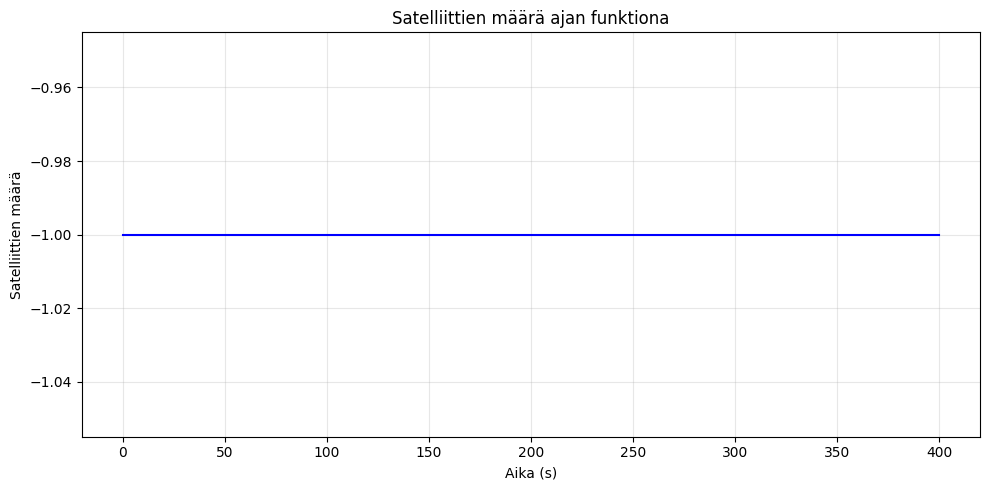

📊 Kuva tallennettu: tarkkuus_aika.png


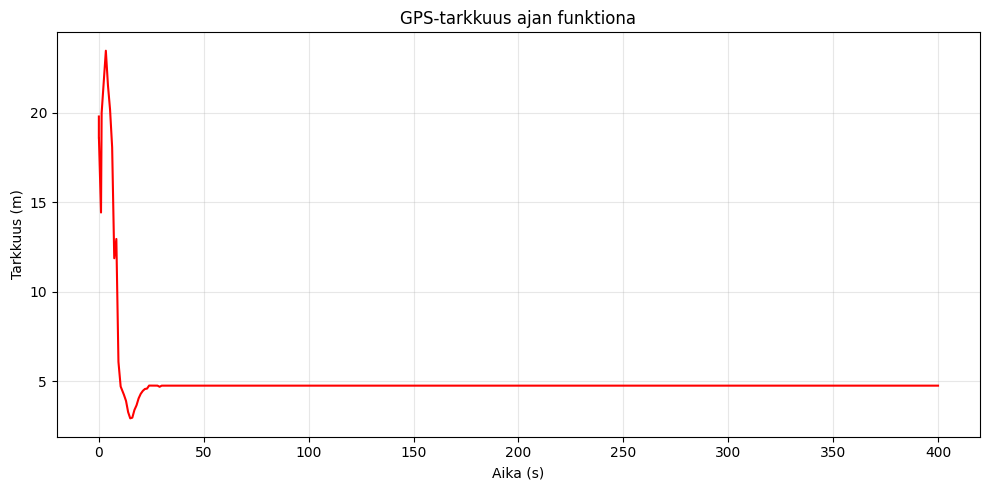

📊 Kuva tallennettu: satelliitit_jakauma.png


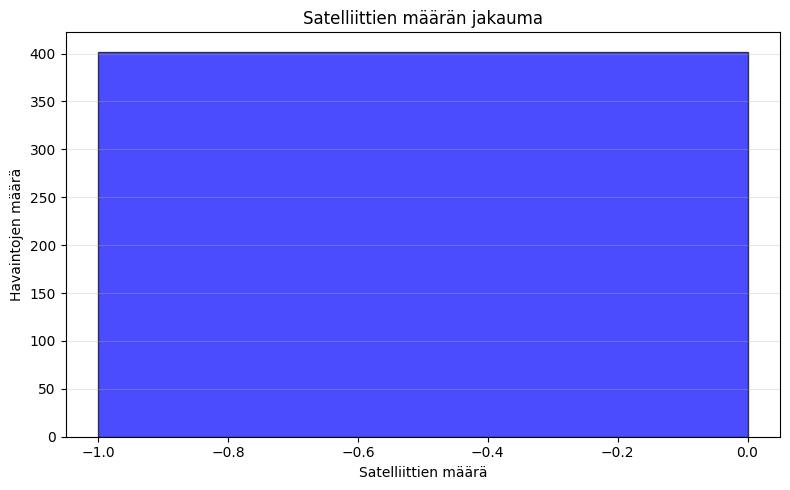

📊 Kuva tallennettu: tarkkuus_jakauma.png


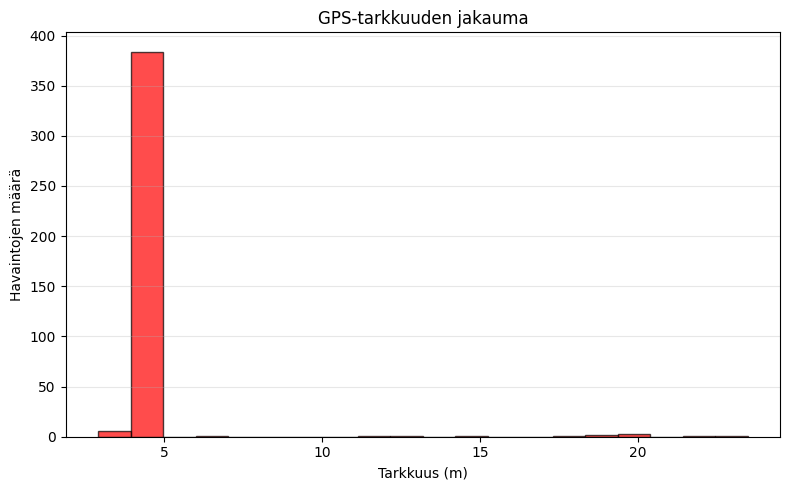

In [53]:
# Kuvaaja 1: Satelliittien määrä ajan funktiona
if "satellites" in df.columns and "time" in df.columns:
    plt.figure(figsize=(10, 5))
    plt.plot(df["time"], df["satellites"], 'b-', linewidth=1.5)
    plt.xlabel("Aika (s)")
    plt.ylabel("Satelliittien määrä")
    plt.title("Satelliittien määrä ajan funktiona")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("satelliitit_aika.png", dpi=150, bbox_inches='tight')
    print("📊 Kuva tallennettu: satelliitit_aika.png")
    plt.show()

# Kuvaaja 2: Tarkkuus ajan funktiona
if "accuracy" in df.columns and "time" in df.columns:
    plt.figure(figsize=(10, 5))
    plt.plot(df["time"], df["accuracy"], 'r-', linewidth=1.5)
    plt.xlabel("Aika (s)")
    plt.ylabel("Tarkkuus (m)")
    plt.title("GPS-tarkkuus ajan funktiona")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("tarkkuus_aika.png", dpi=150, bbox_inches='tight')
    print("📊 Kuva tallennettu: tarkkuus_aika.png")
    plt.show()

# Kuvaaja 3: Satelliittien jakauma
if "satellites" in df.columns:
    plt.figure(figsize=(8, 5))
    plt.hist(df["satellites"], bins=range(int(df["satellites"].min()), int(df["satellites"].max())+2), 
             color='blue', alpha=0.7, edgecolor='black')
    plt.xlabel("Satelliittien määrä")
    plt.ylabel("Havaintojen määrä")
    plt.title("Satelliittien määrän jakauma")
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig("satelliitit_jakauma.png", dpi=150, bbox_inches='tight')
    print("📊 Kuva tallennettu: satelliitit_jakauma.png")
    plt.show()

# Kuvaaja 4: Tarkkuuden jakauma
if "accuracy" in df.columns:
    plt.figure(figsize=(8, 5))
    plt.hist(df["accuracy"], bins=20, color='red', alpha=0.7, edgecolor='black')
    plt.xlabel("Tarkkuus (m)")
    plt.ylabel("Havaintojen määrä")
    plt.title("GPS-tarkkuuden jakauma")
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig("tarkkuus_jakauma.png", dpi=150, bbox_inches='tight')
    print("📊 Kuva tallennettu: tarkkuus_jakauma.png")
    plt.show()

**d) Kuljettu matka (Haversinen kaava)**

In [54]:
# Haversinen kaava kahden GPS-koordinaatin välisen etäisyyden laskemiseen
R = 6371000  # Maan säde metreinä

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Laskee etäisyyden kahden GPS-pisteen välillä Haversinen kaavalla.
    Ottaa huomioon maapallon kaarevuuden.
    """
    # Muutetaan asteet radiaaneiksi
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # Haversinen kaava
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    
    return R * c

# Lasketaan etäisyys jokaiselle peräkkäiselle pisteelle
df["lat_next"] = df["latitude"].shift(-1)
df["lon_next"] = df["longitude"].shift(-1)

df_dist = df.dropna(subset=["lat_next", "lon_next"]).copy()

df_dist["segment_distance_m"] = df_dist.apply(
    lambda row: haversine_distance(
        row["latitude"], row["longitude"],
        row["lat_next"], row["lon_next"]
    ),
    axis=1
)

# Kokonaismatka
total_distance_m = df_dist["segment_distance_m"].sum()
total_distance_km = total_distance_m / 1000

print(f"📏 Kuljettu matka:")
print(f"   • {total_distance_m:.1f} metriä")
print(f"   • {total_distance_km:.3f} kilometriä")

# Lisätiedot ajasta ja nopeudesta
if "time" in df.columns and len(df) > 1:
    total_time = df["time"].max() - df["time"].min()
    if total_time > 0:
        avg_speed_ms = total_distance_m / total_time
        avg_speed_kmh = avg_speed_ms * 3.6
        print(f"\n⏱️ Aika: {total_time:.1f} s ({total_time/60:.1f} min)")
        print(f"🏃 Keskinopeus: {avg_speed_ms:.2f} m/s ({avg_speed_kmh:.2f} km/h)")

📏 Kuljettu matka:
   • 632.2 metriä
   • 0.632 kilometriä

⏱️ Aika: 400.0 s (6.7 min)
🏃 Keskinopeus: 1.58 m/s (5.69 km/h)


**Tarkkuuden kuvaaja**

📊 Tarkkuuden kuvaaja tallennettu: tarkkuus_kuvaaja.png


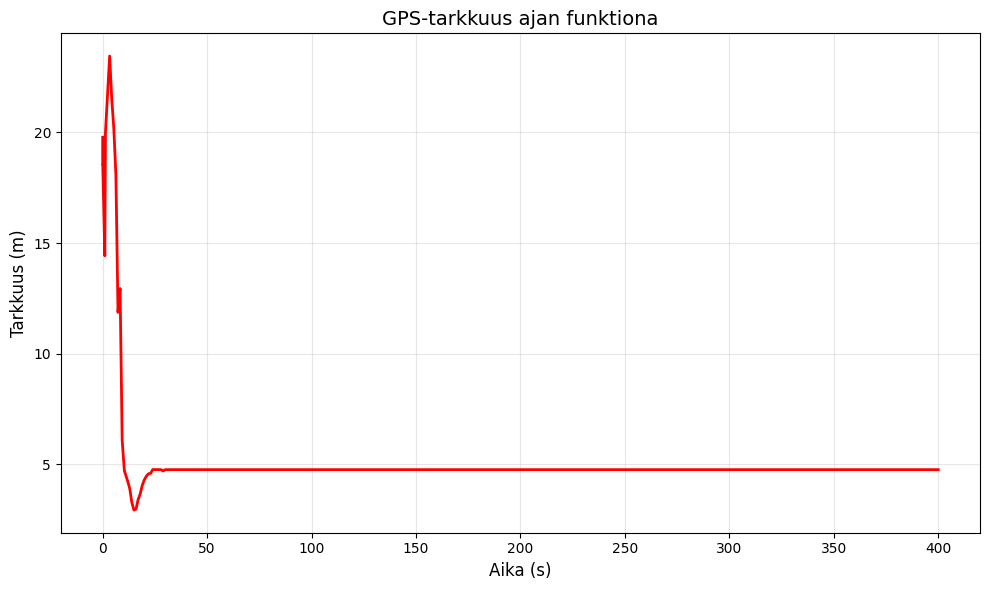

In [55]:
# Tarkkuuden kuvaaja
if "accuracy" in df.columns and "time" in df.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(df["time"], df["accuracy"], 'r-', linewidth=2)
    plt.xlabel("Aika (s)", fontsize=12)
    plt.ylabel("Tarkkuus (m)", fontsize=12)
    plt.title("GPS-tarkkuus ajan funktiona", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("tarkkuus_kuvaaja.png", dpi=150, bbox_inches='tight')
    print("📊 Tarkkuuden kuvaaja tallennettu: tarkkuus_kuvaaja.png")
    plt.show()
else:
    print("⚠️ Tarkkuustietoa ei saatavilla")

**Yhteenveto**

In [56]:
# Yhteenveto ja tulostus
print("\n" + "="*60)
print("📊 GPS-REITIN ANALYYSI - YHTEENVETO")
print("="*60)

print("\n🗺️ TEHTÄVÄ A: Reitti kartalla")
print(f"   • Kartta tallennettu: {map_filename}")
print(f"   • Datapisteitä yhteensä: {len(df)}")
print(f"   • Lähtöpiste: ({route[0][0]:.6f}, {route[0][1]:.6f})")
print(f"   • Loppupiste: ({route[-1][0]:.6f}, {route[-1][1]:.6f})")

print("\n📡 TEHTÄVÄ B: Mittauksen luotettavuus")
if "satellites" in df.columns:
    print(f"   Satelliitit:")
    print(f"   • Keskimäärin: {df['satellites'].mean():.1f}")
    print(f"   • Min-Max: {int(df['satellites'].min())} - {int(df['satellites'].max())}")
else:
    print("   • Satelliittitietoa ei saatavilla")

if "accuracy" in df.columns:
    print(f"   GPS-tarkkuus:")
    print(f"   • Keskimäärin: {df['accuracy'].mean():.1f} m")
    print(f"   • Paras: {df['accuracy'].min():.1f} m")
    print(f"   • Huonoin: {df['accuracy'].max():.1f} m")
else:
    print("   • Tarkkuustietoa ei saatavilla")

print("\n📊 TEHTÄVÄ C: Visualisoinnit")
print("   Kuvaajat tallennettu:")
if "satellites" in df.columns and "time" in df.columns:
    print("   ✓ satelliitit_aika.png")
    print("   ✓ satelliitit_jakauma.png")
if "accuracy" in df.columns and "time" in df.columns:
    print("   ✓ tarkkuus_aika.png")
    print("   ✓ tarkkuus_jakauma.png")

print("\n📏 TEHTÄVÄ D: Kuljettu matka (Haversine)")
print(f"   • Matka: {total_distance_m:.1f} m ({total_distance_km:.3f} km)")

if "time" in df.columns and len(df) > 1:
    total_time = df["time"].max() - df["time"].min()
    if total_time > 0:
        avg_speed_ms = total_distance_m / total_time
        avg_speed_kmh = avg_speed_ms * 3.6
        print(f"   • Aika: {total_time:.1f} s ({total_time/60:.1f} min)")
        print(f"   • Keskinopeus: {avg_speed_ms:.2f} m/s ({avg_speed_kmh:.2f} km/h)")

print("\n" + "="*60)
print("✅ ANALYYSI VALMIS!")
print("="*60)
print("\nLuodut tiedostot raporttia varten:")
print(f"  1. {map_filename} - Interaktiivinen kartta")
print(f"  2. satelliitit_aika.png - Satelliittien määrä ajassa")
print(f"  3. tarkkuus_aika.png - GPS-tarkkuus ajassa")
print(f"  4. satelliitit_jakauma.png - Satelliittien jakauma")
print(f"  5. tarkkuus_jakauma.png - Tarkkuuden jakauma")
print("\nKaikki tiedostot on tallennettu samaan kansioon GPS.csv-tiedoston kanssa.")
print("\n💡 Voit nyt luoda raportin käyttäen näitä tiedostoja!")


📊 GPS-REITIN ANALYYSI - YHTEENVETO

🗺️ TEHTÄVÄ A: Reitti kartalla
   • Kartta tallennettu: reitti_phyphox.html
   • Datapisteitä yhteensä: 402
   • Lähtöpiste: (62.501261, 25.432891)
   • Loppupiste: (62.501237, 25.433009)

📡 TEHTÄVÄ B: Mittauksen luotettavuus
   Satelliitit:
   • Keskimäärin: -1.0
   • Min-Max: -1 - -1
   GPS-tarkkuus:
   • Keskimäärin: 5.1 m
   • Paras: 2.9 m
   • Huonoin: 23.5 m

📊 TEHTÄVÄ C: Visualisoinnit
   Kuvaajat tallennettu:
   ✓ satelliitit_aika.png
   ✓ satelliitit_jakauma.png
   ✓ tarkkuus_aika.png
   ✓ tarkkuus_jakauma.png

📏 TEHTÄVÄ D: Kuljettu matka (Haversine)
   • Matka: 632.2 m (0.632 km)
   • Aika: 400.0 s (6.7 min)
   • Keskinopeus: 1.58 m/s (5.69 km/h)

✅ ANALYYSI VALMIS!

Luodut tiedostot raporttia varten:
  1. reitti_phyphox.html - Interaktiivinen kartta
  2. satelliitit_aika.png - Satelliittien määrä ajassa
  3. tarkkuus_aika.png - GPS-tarkkuus ajassa
  4. satelliitit_jakauma.png - Satelliittien jakauma
  5. tarkkuus_jakauma.png - Tarkkuuden j